Author: Akash Kharita
Date: Last updated on 10/7/2024

In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


import numpy as np
import scipy.signal as signal



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Get the current working directory
notebook_dir = os.getcwd()

# Add the ../src directory to the Python path
src_path = os.path.abspath(os.path.join(notebook_dir, 'scripts'))
sys.path.insert(0, src_path)

from neural_network_architectures import MyCNN_1d
from neural_network_architectures import MyCNN_2d
from neural_network_architectures import MyCNN_1d_on_2d

from neural_network_architectures import SeismicCNN_1d
from neural_network_architectures import SeismicCNN_2d

from neural_network_architectures import MyResCNN_1d
from neural_network_architectures import MyResCNN_2d


from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr

cuda
cuda
cuda


## Reading the metadata

In [2]:
#data files
file_noise="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


## Filtered by SNR

In [3]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

## Extracting waveform data and event ids

In [5]:
num_channels = 3
number_data_per_class = 8434 ## This is equal to the total number of the samples in the minority class.

# new sampling rate
fs = 50

nos = 2000

# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = -20
shifting = True

# training parameters
train_split = 70                                      
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100


# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)

# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)



# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)


  0%|          | 20/8434 [00:00<00:43, 191.68it/s]

(3712, 3, 5000)


  0%|          | 19/8434 [00:00<00:44, 187.28it/s]

(5940, 3, 5000)


  0%|          | 11/8434 [00:00<01:22, 101.68it/s]

(6207, 3, 5000)


100%|██████████| 8434/8434 [01:21<00:00, 103.12it/s]


(5619, 3, 5000)


## Balancing the classes, creating 1D input

In [6]:
# concatenate all data into one input
X_1d = np.vstack([d_eq[0:nos], d_exp[0:nos], d_noise[0:nos], d_su[0:nos]])

## Creating 2D input

In [7]:
s_su = extract_spectrograms(waveforms = d_su[0:nos])
s_noise = extract_spectrograms(waveforms = d_noise[0:nos])
s_eq = extract_spectrograms(waveforms = d_eq[0:nos])
s_exp = extract_spectrograms(waveforms = d_exp[0:nos])

# concatenate all data into one input
X_2d = np.vstack([s_eq, s_exp, s_noise, s_su])

  7%|▋         | 143/2000 [00:00<00:01, 1426.16it/s]

(2000, 3, 129, 38)


  7%|▋         | 143/2000 [00:00<00:01, 1428.05it/s]

(2000, 3, 129, 38)


  7%|▋         | 143/2000 [00:00<00:01, 1422.50it/s]

(2000, 3, 129, 38)


100%|██████████| 2000/2000 [00:01<00:00, 1425.31it/s]


(2000, 3, 129, 38)


## Setting up the labels (this will be converted to one hot encoding in the train model function)

In [8]:
y = [0]*len(d_eq[0:nos])+[1]*len(d_exp[0:nos])+[2]*len(d_noise[0:nos])+[3]*len(d_su[0:nos])

## Creating the dataloaders

In [9]:
## Preparing the data loaders for 1d and 2d inputs
train_loader_1d, val_loader_1d, test_loader_1d = return_train_test_val_loaders(X = X_1d, y = y, train_split = train_split, test_split = test_split, val_split = val_split, batch_size = batch_size)
train_loader_2d, val_loader_2d, test_loader_2d = return_train_test_val_loaders(X = X_2d, y = y, train_split = train_split, test_split = test_split, val_split = val_split, batch_size = batch_size)

43 12 6
43 12 6


## Training and testing the models

## SeismicCNN 1D

In [10]:
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d,test_loss_seismiccnn_1d,test_accuracy_seismiccnn_1d) = train_model(model_seismiccnn_1d,
    train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:09<00:45,  1.10it/s]

[Epoch 10] loss: 0.273 - accuracy: 63.477


 33%|███▎      | 20/60 [00:19<00:37,  1.05it/s]

[Epoch 20] loss: 0.143 - accuracy: 72.201


 50%|█████     | 30/60 [00:28<00:28,  1.04it/s]

[Epoch 30] loss: 0.085 - accuracy: 73.958


 67%|██████▋   | 40/60 [00:37<00:17,  1.16it/s]

[Epoch 40] loss: 0.064 - accuracy: 76.693


 83%|████████▎ | 50/60 [00:46<00:09,  1.07it/s]

[Epoch 50] loss: 0.046 - accuracy: 78.971


100%|██████████| 60/60 [00:56<00:00,  1.07it/s]

[Epoch 60] loss: 0.036 - accuracy: 77.930
test loss: 0.619 and accuracy: 80.078



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

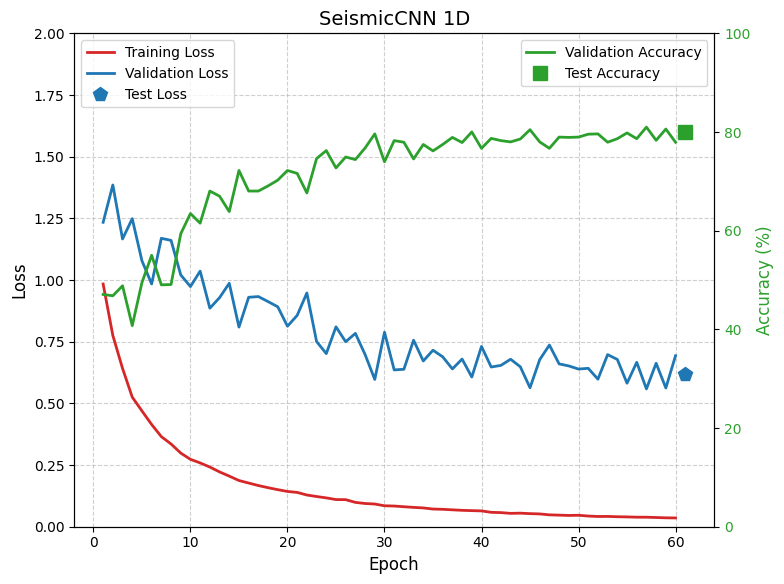

In [12]:
def plot_model_training(loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy, title = 'SeismicCNN 1D'):


    # Assuming loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy are defined

    NN = np.count_nonzero(loss_time)
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability

    # Set font sizes
    plt.style.use('default')
    plt.rc('font', size=12)  # Global font size
    plt.rc('axes', titlesize=14)  # Title font size
    plt.rc('axes', labelsize=12)  # Axis label font size
    plt.rc('xtick', labelsize=10)  # X-axis tick label font size
    plt.rc('ytick', labelsize=10)  # Y-axis tick label font size

    # Plot Training and Validation Loss
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.plot(np.arange(1, NN+1), loss_time[:NN], color='tab:red', label='Training Loss', linewidth=2)
    ax1.plot(np.arange(1, NN+1), val_loss_time[:NN], color='tab:blue', label='Validation Loss', linewidth=2)
    ax1.plot(NN+1, test_loss, 'p', color='tab:blue', label='Test Loss', markersize=10)
    ax1.set_ylim(0, 2)
    ax1.grid(True, linestyle='--', alpha=0.6)  # Add grid with some transparency

    # Twin axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='tab:green')
    ax2.plot(np.arange(1, NN+1), val_accuracy_time[:NN], color='tab:green', label='Validation Accuracy', linewidth=2)
    ax2.plot(NN+1, test_accuracy, 's', color='tab:green', label='Test Accuracy', markersize=10)
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.grid(False)

    # Title and legend
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add legends for both axes
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Save the figure with high resolution
    plt.savefig(f"../figures/{title}", dpi=300, bbox_inches='tight')

    plt.show()

plot_model_training(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d, test_loss_seismiccnn_1d, test_accuracy_seismiccnn_1d)

test loss: 0.634 and accuracy: 79.297


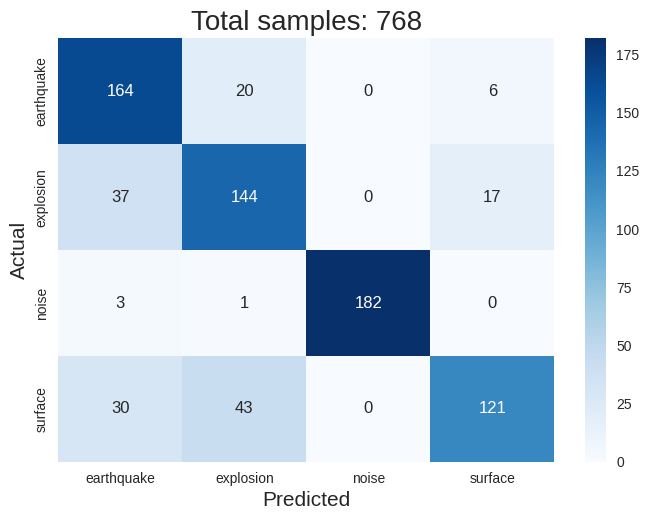

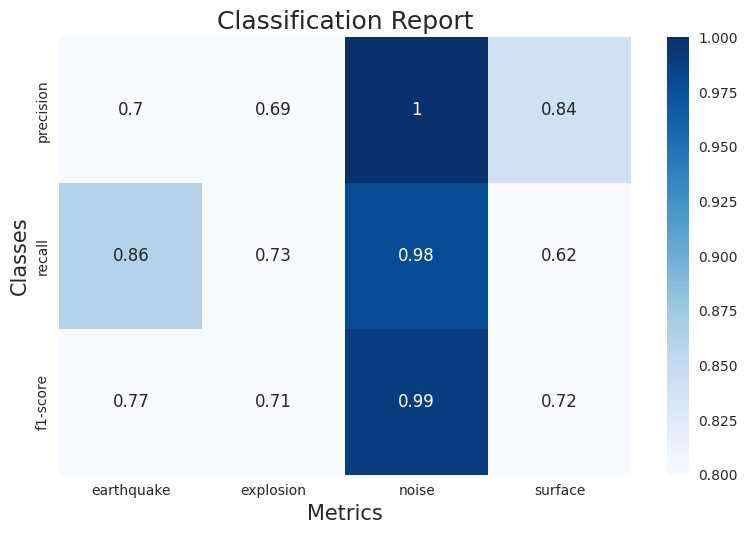

In [14]:
_,_ = plot_confusion_matrix_and_cr(model_seismiccnn_1d, test_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## SeismicCNN 2D

In [16]:
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d,test_loss_seismiccnn_2d,test_accuracy_seismiccnn_2d) = train_model(model_seismiccnn_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_' )

 17%|█▋        | 10/60 [00:07<00:38,  1.30it/s]

[Epoch 10] loss: 0.461 - accuracy: 81.901


 33%|███▎      | 20/60 [00:14<00:27,  1.47it/s]

[Epoch 20] loss: 0.320 - accuracy: 85.026


 50%|█████     | 30/60 [00:21<00:20,  1.49it/s]

[Epoch 30] loss: 0.238 - accuracy: 85.352


 67%|██████▋   | 40/60 [00:27<00:13,  1.49it/s]

[Epoch 40] loss: 0.187 - accuracy: 87.240


 83%|████████▎ | 50/60 [00:34<00:06,  1.48it/s]

[Epoch 50] loss: 0.146 - accuracy: 87.305


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]

[Epoch 60] loss: 0.112 - accuracy: 87.565
test loss: 0.366 and accuracy: 87.891



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

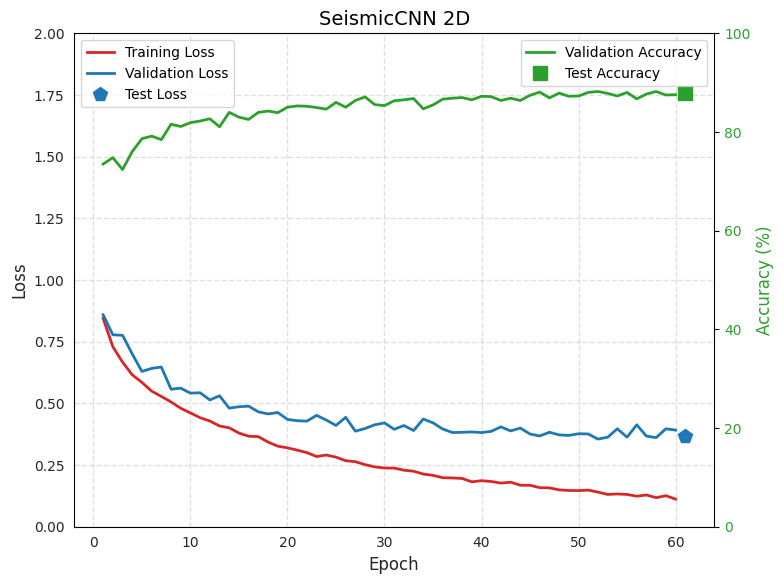

In [17]:
plot_model_training(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, test_loss_seismiccnn_2d, test_accuracy_seismiccnn_2d, title = 'SeismicCNN 2D')

test loss: 0.357 and accuracy: 88.411


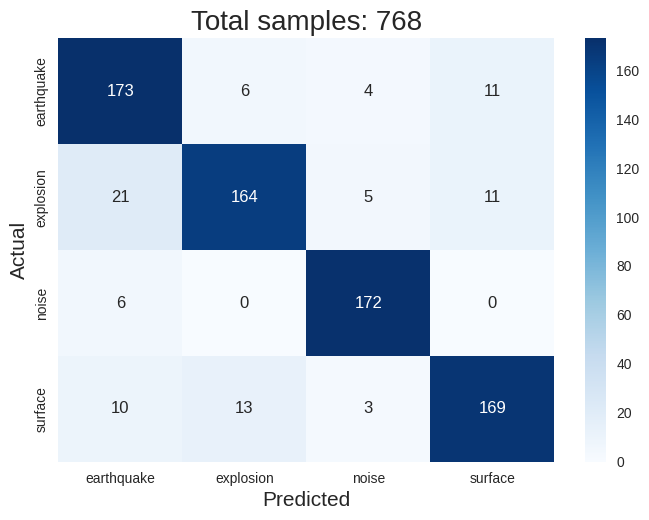

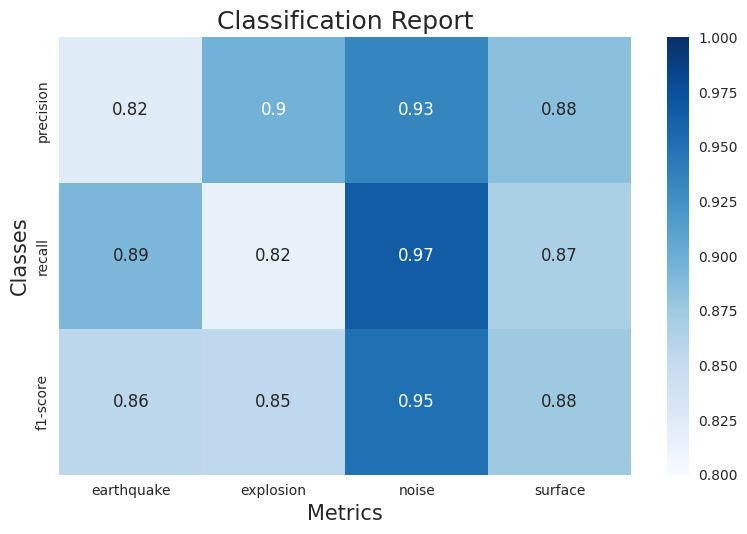

In [18]:
model_seismiccnn_2d.eval()
_,_ = plot_confusion_matrix_and_cr(model_seismiccnn_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## MyCNN 1D

In [19]:
model_mycnn_1d = MyCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_1d, val_loss_time_mycnn_1d, val_accuracy_time_mycnn_1d,test_loss_mycnn_1d,test_accuracy_mycnn_1d) = train_model(model_mycnn_1d,
    train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:07<00:40,  1.24it/s]

[Epoch 10] loss: 0.430 - accuracy: 77.995


 33%|███▎      | 20/60 [00:15<00:31,  1.27it/s]

[Epoch 20] loss: 0.318 - accuracy: 80.208


 50%|█████     | 30/60 [00:22<00:21,  1.42it/s]

[Epoch 30] loss: 0.253 - accuracy: 83.789


 67%|██████▋   | 40/60 [00:29<00:13,  1.43it/s]

[Epoch 40] loss: 0.212 - accuracy: 88.867


 83%|████████▎ | 50/60 [00:36<00:06,  1.43it/s]

[Epoch 50] loss: 0.176 - accuracy: 87.891


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]

[Epoch 60] loss: 0.146 - accuracy: 88.932
test loss: 0.332 and accuracy: 89.193



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

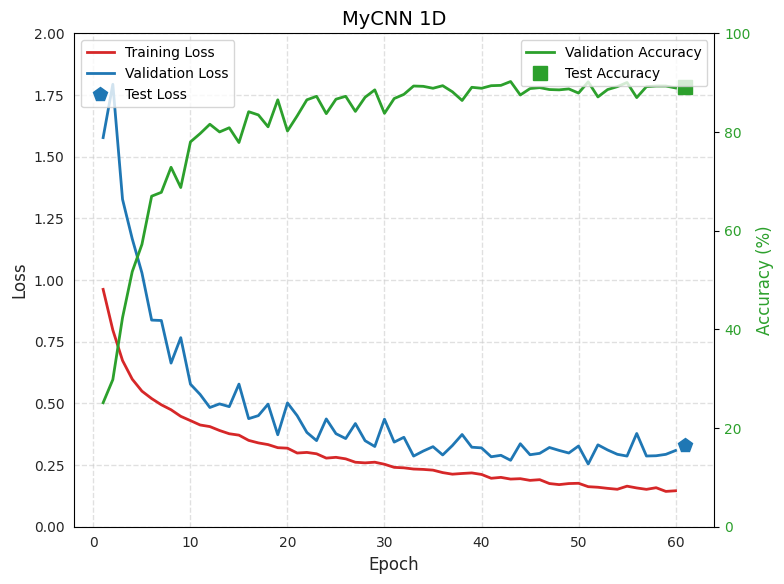

In [20]:
plot_model_training(loss_time_mycnn_1d, val_loss_time_mycnn_1d, val_accuracy_time_mycnn_1d, test_loss_mycnn_1d, test_accuracy_mycnn_1d, title = 'MyCNN 1D')

test loss: 0.336 and accuracy: 88.932


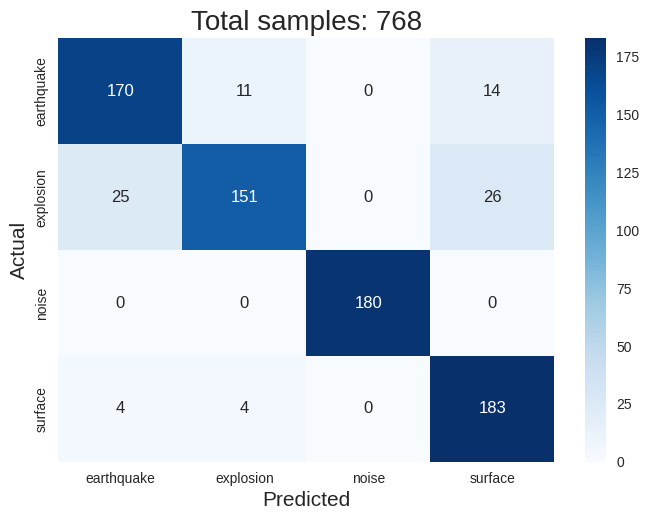

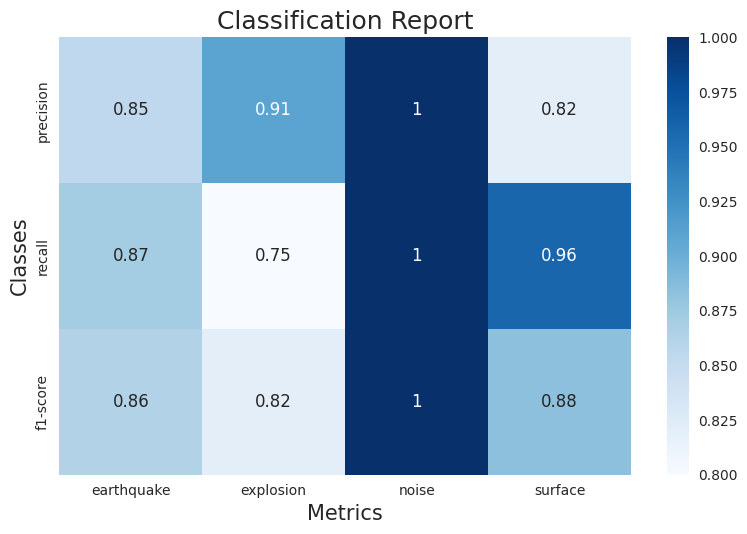

In [22]:
model_mycnn_1d.eval()
_,_ = plot_confusion_matrix_and_cr(model_mycnn_1d, test_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## MyCNN 2D

In [23]:
model_mycnn_2d = MyCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_2d, val_loss_time_mycnn_2d, val_accuracy_time_mycnn_2d,test_loss_mycnn_2d,test_accuracy_mycnn_2d) = train_model(model_mycnn_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:06<00:30,  1.63it/s]

[Epoch 10] loss: 0.656 - accuracy: 76.562


 33%|███▎      | 20/60 [00:12<00:24,  1.63it/s]

[Epoch 20] loss: 0.542 - accuracy: 82.552


 50%|█████     | 30/60 [00:18<00:18,  1.64it/s]

[Epoch 30] loss: 0.478 - accuracy: 83.789


 67%|██████▋   | 40/60 [00:24<00:12,  1.64it/s]

[Epoch 40] loss: 0.427 - accuracy: 86.133


 83%|████████▎ | 50/60 [00:30<00:06,  1.64it/s]

[Epoch 50] loss: 0.408 - accuracy: 87.044


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]

[Epoch 60] loss: 0.377 - accuracy: 86.589
test loss: 0.373 and accuracy: 86.849



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

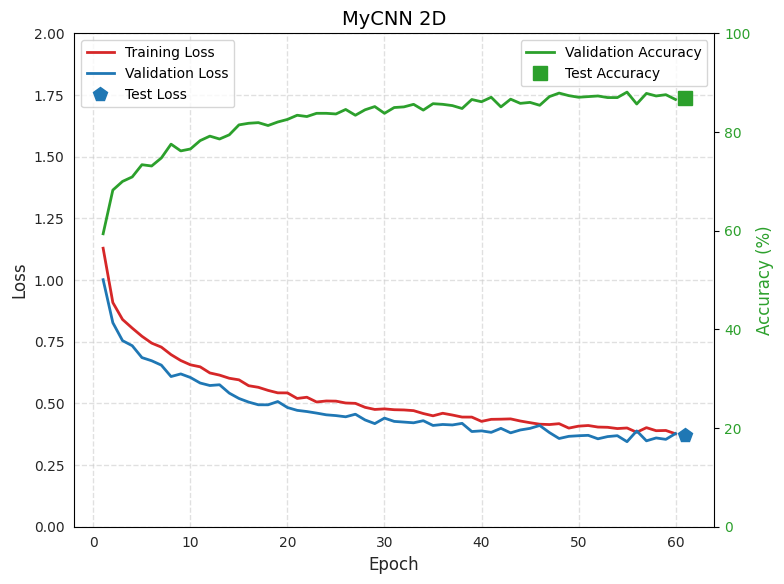

In [24]:
plot_model_training(loss_time_mycnn_2d, val_loss_time_mycnn_2d, val_accuracy_time_mycnn_2d, test_loss_mycnn_2d, test_accuracy_mycnn_2d, title = 'MyCNN 2D')

test loss: 0.376 and accuracy: 86.719


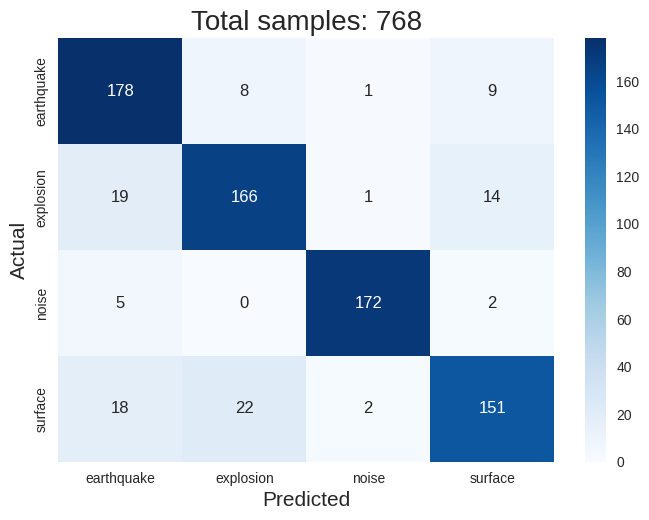

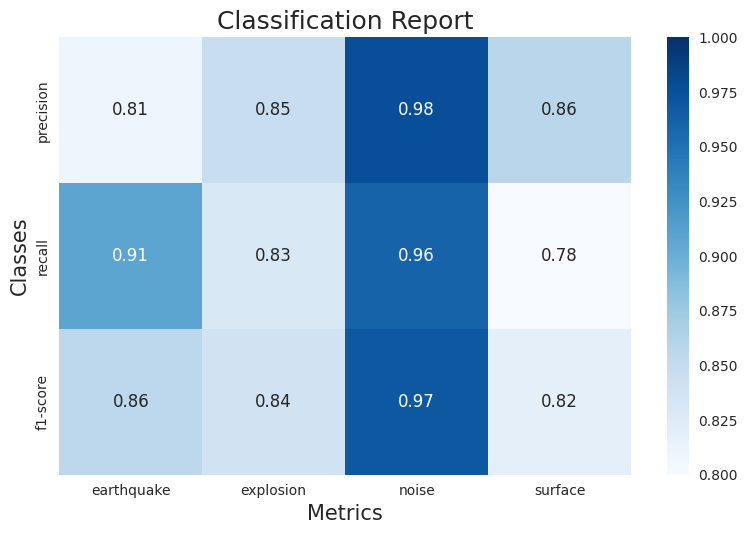

In [25]:
model_mycnn_2d.eval()
_,_ = plot_confusion_matrix_and_cr(model_mycnn_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## MyCNN 1D on 2D

In [26]:
model_mycnn_1d_on_2d = MyCNN_1d_on_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_1d_on_2d, val_loss_time_mycnn_1d_on_2d, val_accuracy_time_mycnn_1d_on_2d,test_loss_mycnn_1d_on_2d,test_accuracy_mycnn_1d_on_2d) = train_model(model_mycnn_1d_on_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30,  model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:06<00:33,  1.51it/s]

[Epoch 10] loss: 0.531 - accuracy: 78.841


 33%|███▎      | 20/60 [00:13<00:26,  1.53it/s]

[Epoch 20] loss: 0.403 - accuracy: 81.641


 50%|█████     | 30/60 [00:19<00:19,  1.53it/s]

[Epoch 30] loss: 0.336 - accuracy: 82.943


 67%|██████▋   | 40/60 [00:26<00:13,  1.52it/s]

[Epoch 40] loss: 0.273 - accuracy: 86.263


 83%|████████▎ | 50/60 [00:32<00:06,  1.53it/s]

[Epoch 50] loss: 0.223 - accuracy: 86.198


100%|██████████| 60/60 [00:39<00:00,  1.52it/s]

[Epoch 60] loss: 0.195 - accuracy: 84.831
test loss: 0.382 and accuracy: 88.281



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

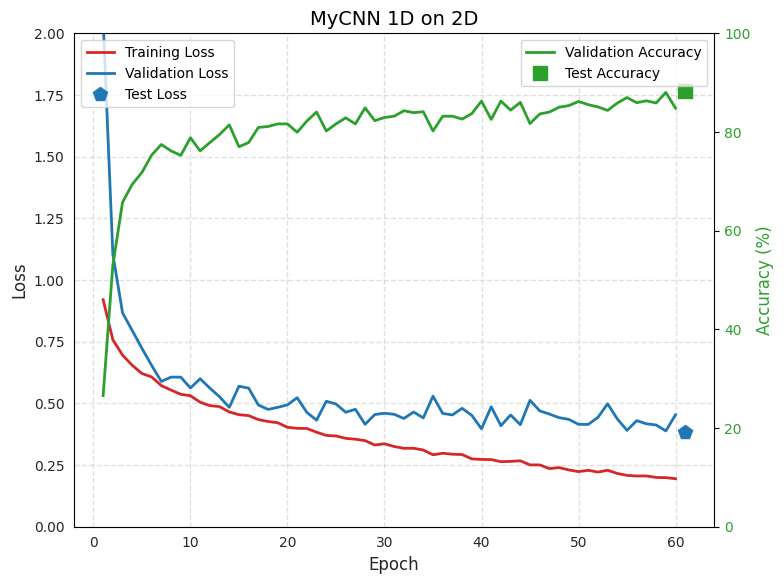

In [27]:
plot_model_training(loss_time_mycnn_1d_on_2d, val_loss_time_mycnn_1d_on_2d, val_accuracy_time_mycnn_1d_on_2d, test_loss_mycnn_1d_on_2d, test_accuracy_mycnn_1d_on_2d, title = 'MyCNN 1D on 2D')

test loss: 0.389 and accuracy: 87.891


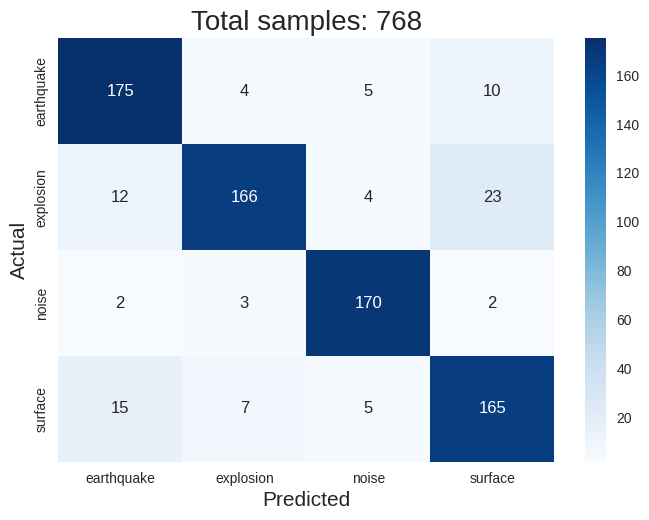

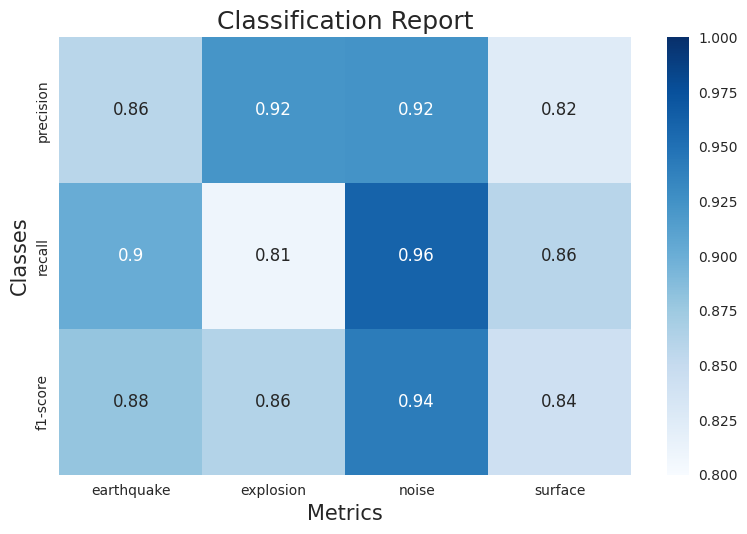

In [28]:
model_mycnn_1d_on_2d.eval()
_,_ = plot_confusion_matrix_and_cr(model_mycnn_1d_on_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## MyResCNN 1D

In [31]:
model_myrescnn_1d = MyResCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_myrescnn_1d, val_loss_time_myrescnn_1d, val_accuracy_time_myrescnn_1d,test_loss_myrescnn_1d,test_accuracy_myrescnn_1d) = train_model(model_myrescnn_1d,
    train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:10<00:53,  1.07s/it]

[Epoch 10] loss: 0.590 - accuracy: 65.495


 33%|███▎      | 20/60 [00:21<00:42,  1.07s/it]

[Epoch 20] loss: 0.517 - accuracy: 65.625


 50%|█████     | 30/60 [00:32<00:32,  1.07s/it]

[Epoch 30] loss: 0.475 - accuracy: 67.188


 67%|██████▋   | 40/60 [00:42<00:21,  1.07s/it]

[Epoch 40] loss: 0.454 - accuracy: 80.143


 83%|████████▎ | 50/60 [00:53<00:10,  1.07s/it]

[Epoch 50] loss: 0.420 - accuracy: 68.880


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]

[Epoch 60] loss: 0.403 - accuracy: 75.130
test loss: 0.532 and accuracy: 80.729



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

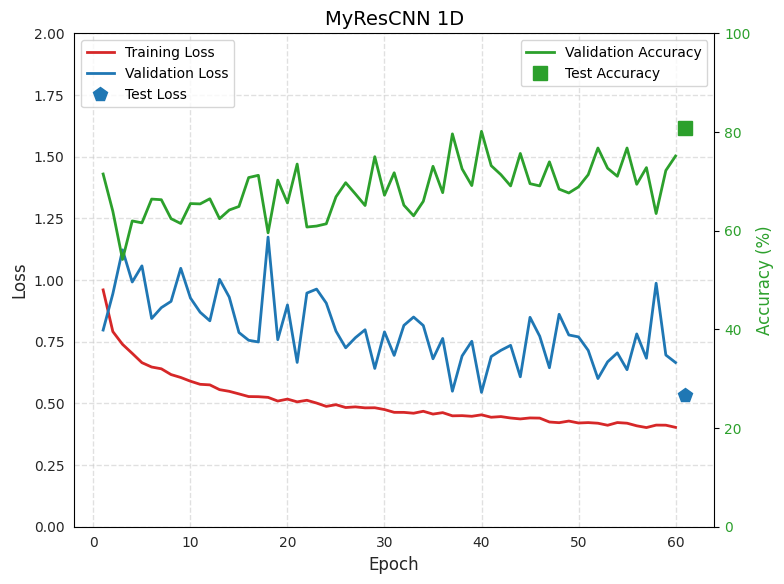

In [32]:
plot_model_training(loss_time_myrescnn_1d, val_loss_time_myrescnn_1d, val_accuracy_time_myrescnn_1d, test_loss_myrescnn_1d, test_accuracy_myrescnn_1d, title = 'MyResCNN 1D')

test loss: 0.538 and accuracy: 80.208


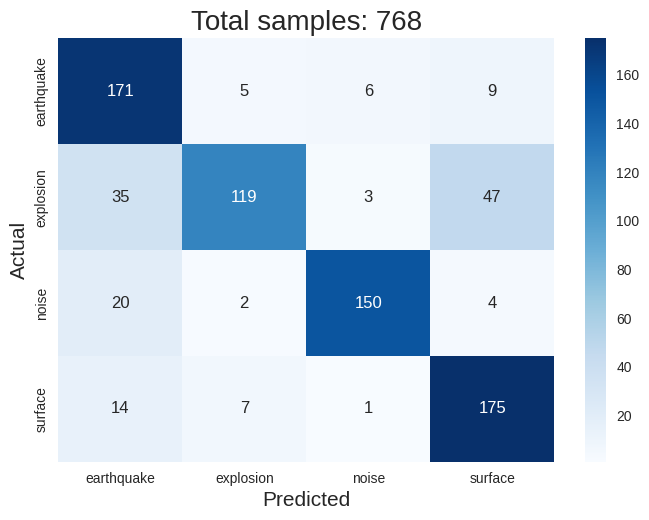

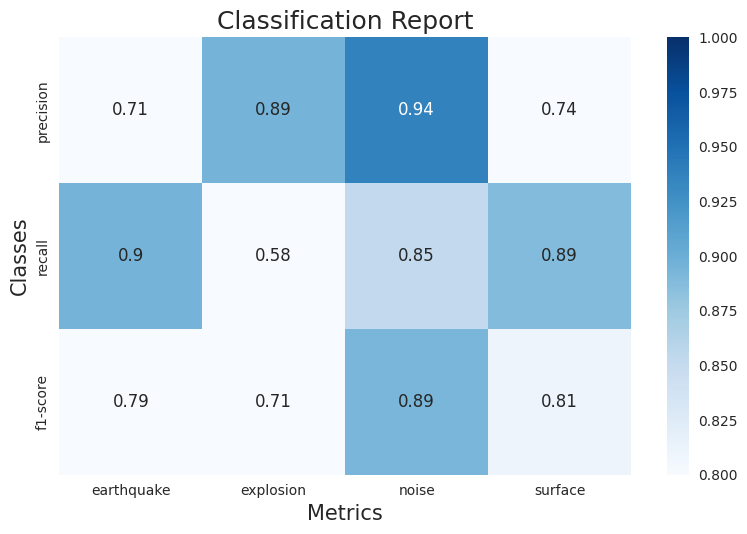

In [34]:
model_myrescnn_1d.eval()
_,_ = plot_confusion_matrix_and_cr(model_myrescnn_1d, test_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## MyResCNN 2D

In [36]:
model_myrescnn_2d = MyResCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_myrescnn_2d, val_loss_time_myrescnn_2d, val_accuracy_time_myrescnn_2d,test_loss_myrescnn_2d,test_accuracy_myrescnn_2d) = train_model(model_myrescnn_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:06<00:32,  1.56it/s]

[Epoch 10] loss: 0.337 - accuracy: 80.990


 33%|███▎      | 20/60 [00:12<00:25,  1.56it/s]

[Epoch 20] loss: 0.209 - accuracy: 87.891


 50%|█████     | 30/60 [00:19<00:19,  1.56it/s]

[Epoch 30] loss: 0.129 - accuracy: 77.669


 67%|██████▋   | 40/60 [00:25<00:12,  1.56it/s]

[Epoch 40] loss: 0.105 - accuracy: 84.505


 75%|███████▌  | 45/60 [00:29<00:09,  1.52it/s]

test loss: 0.339 and accuracy: 87.240



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

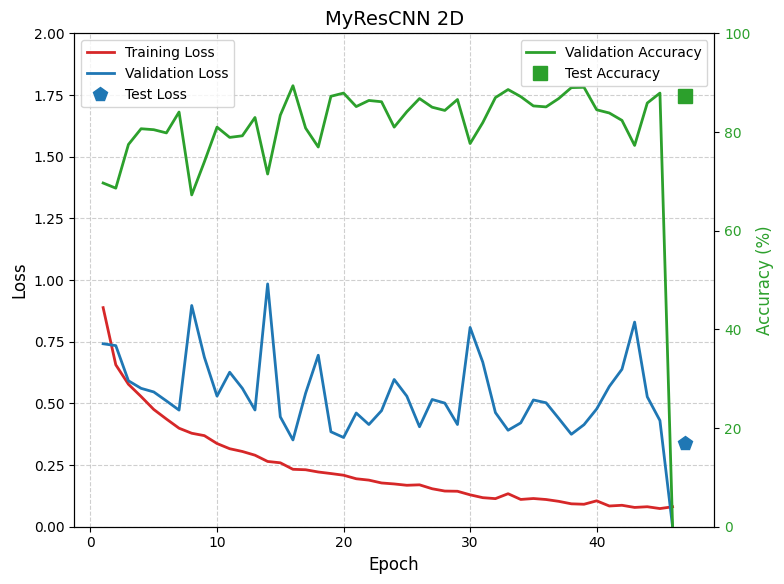

In [38]:
plot_model_training(loss_time_myrescnn_2d, val_loss_time_myrescnn_2d, val_accuracy_time_myrescnn_2d, test_loss_myrescnn_2d, test_accuracy_myrescnn_2d, title = 'MyResCNN 2D')

test loss: 0.347 and accuracy: 86.979


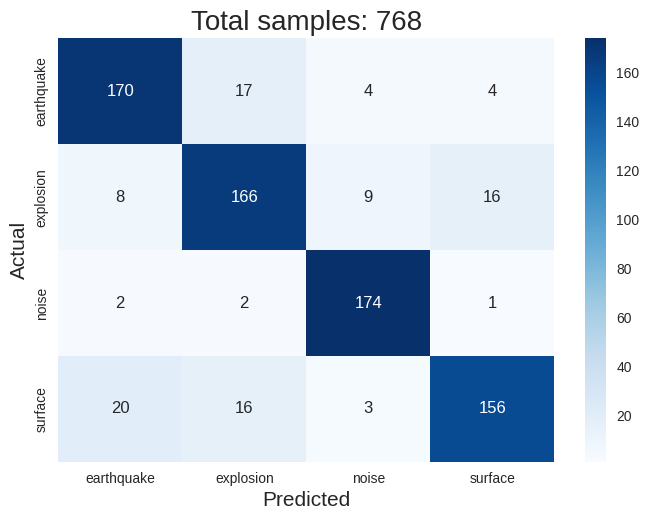

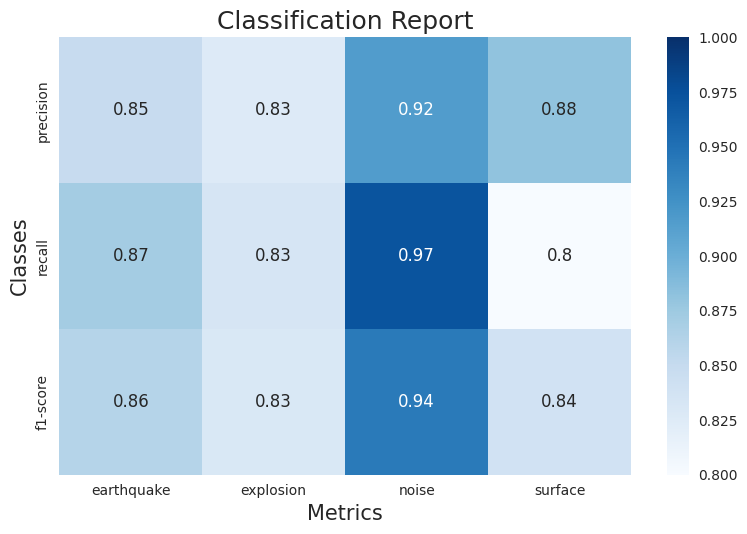

In [39]:
model_myrescnn_2d.eval()
_,_  = plot_confusion_matrix_and_cr(model_myrescnn_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)